In [38]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [67]:
d = '/Users/abrahamn/Documents/Physics/papers/DishPapers/data/'
visdatrich = np.load(d+'14.0m_dish_multi_baseline_visibilities_no_ground_drift_80x1080.0s_baseline_range_14.6-58.4_asm_all_sky_sprms_0.0_nside_256_derr_0.000ns_gerr_0.00dB_nrand_1_Tsys_220.0K_128x781.2_kHz_150.0_MHz_extpb_RBAN_137.5_MHz_achromatic_no_pfb.npz')
visdatdave = np.load(d+'14.0m_dish_multi_baseline_visibilities_no_ground_drift_80x1080.0s_baseline_range_14.6-58.4_asm_all_sky_sprms_0.0_nside_256_derr_0.000ns_gerr_0.00dB_nrand_1_Tsys_220.0K_128x781.2_kHz_150.0_MHz_extpb_DDAN_137.5_MHz_achromatic_no_pfb.npz')

richarea = 68.9
davearea = 83.8

In [40]:
visdatrich.files

['vis_freq',
 'bl',
 'timestamp',
 'skyvis_freq',
 'bl_length',
 'lst',
 'vis_noise_freq',
 'freq']

In [48]:
freqs = visdatrich['freq']
dfHz = freqs[1]-freqs[0]

desiredcenterfreq = 150.e6
desiredcenterindex = int((desiredcenterfreq-freqs[0])/dfHz)
bandbandwidth = 95.e6 # Hz
desirednfreqs = bandbandwidth/dfHz
desiredindices = arange(len(freqs))[arange(int(desiredcenterindex-desirednfreqs/2),int(desiredcenterindex+desirednfreqs/2))]

bandfreqs = freqs[desiredindices]
numbandfreqs = len(bandfreqs)
dfHz = bandfreqs[1]-bandfreqs[0]
centerbandfreq = mean(bandfreqs)
centerbandlamda = 3.e8/centerbandfreq

z = 1420.e6/centerbandfreq-1
Ez = sqrt(.3*(1+z)**3+.7)
H0overc = 2.335e-4 # 1/Mpc

In [49]:
# Theory power spectrum from Zaki's PAPER-64 paper
theorydat2 = genfromtxt('/Users/abrahamn/Documents/Physics/papers/beamforming_errors_in_mwa_tiles/model_power_spectrum8_4.txt',skip_header=2)
theorykpara2 = theorydat2[:,0]
theorypowerspectrum2 = theorydat2[:,1]/abs(theorykpara2)**3*(2*pi**2)
theorydelays2 = theorykpara2*(1+z)**2/(H0overc*2*pi*1420.e6*Ez)*1.e9

# Theory power spectrum generated by Aaron
theorydat = genfromtxt('/Users/abrahamn/Documents/Physics/papers/beamforming_errors_in_mwa_tiles/aaron_theory_power_spectrum.txt',skip_header=2)
theorykpara = theorydat[:,0]
theorypowerspectrum = theorydat[:,1]/abs(theorykpara)**3*(2*pi**2)

theorydelays = theorykpara*(1+z)**2/(H0overc*2*pi*1420.e6*Ez)*1.e9

#blhorizondelayns = array(blmeters)*3.28
datadelays = roll(fft.fftfreq(numbandfreqs, d=dfHz),numbandfreqs/2)*1.e9 # df as defined above i
datakpara = datadelays*1.e-9*(H0overc*2*pi*1420.e6*Ez)/(1+z)**2

In [55]:
# See Section 2 of http://iopscience.iop.org/0004-637X/804/1/14/pdf/0004-637X_804_1_14.pdf
# for details on conversion from FFT of visibilities to cosmological power spectrum units

import scipy.signal

kb=1.38e-23 # J/K
D = 9285.5 # LOS comoving distance to z=8.5
H0overc = 2.335e-4 # 1/Mpc

def vis_to_delay_spec(vis,A):
    wind = scipy.signal.blackmanharris(numbandfreqs)
    vis_ft = roll(fft.fft(vis*wind),numbandfreqs/2)/sqrt(np.mean(wind**2))
    
    deltaD = bandbandwidth/(150.e6*Ez*H0overc)
    units = D**2*deltaD*centerbandlamda**2/(bandbandwidth**2*4*kb**2)*(1.e-26*dfHz)**2#*1.e6
    
    datadelays = roll(fft.fftfreq(numbandfreqs, d=dfHz),numbandfreqs/2)*1.e9 # df as defined above i
    
    return datadelays,vis_ft*sqrt(units*A)

In [51]:
matplotlib.rcParams.update({'font.size': 18})

def plotjunk(ax,hordelay,myxlim):
    # cosmology power spectra
    ax.semilogy(theorydelays,theorypowerspectrum*1.e-6,'k:',linewidth=2,label='1D theory')
    ax.semilogy(-theorydelays,theorypowerspectrum*1.e-6,'k:',linewidth=2)
    plt.legend(fontsize=10)

    # other plotting stuff
    ax.semilogy([-hordelay,-hordelay],[1.e-6,2.e18],'k-')
    ax.semilogy([hordelay,hordelay],[1.e-6,2.e18],'k-')
    plt.ylim([1.e-4,1.e11])
    plt.xlim(myxlim)
    plt.xlabel(r"$\tau$ (ns)")
    plt.ylabel(r"$P(k)$  $(\mathrm{Mpc}^3 \mathrm{K}^2)$")
    ax2 = ax.twiny()
    delayticks = ax.get_xticks()
    kparaticks = array([-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6])
    kparaticksdelays = kparaticks*(1+z)**2/(H0overc*2*pi*1420.e6*Ez)*1.e9
    ax2.set_xticks(kparaticksdelays)
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels(["%.1f"%kpara for kpara in kparaticks])
    ax2.set_xlabel(r"$k_\parallel$ $(\mathrm{Mpc}^{-1})$")

In [52]:
visdatrich['freq'][desiredindices]/1.e6

array([ 102.34375,  103.125  ,  103.90625,  104.6875 ,  105.46875,
        106.25   ,  107.03125,  107.8125 ,  108.59375,  109.375  ,
        110.15625,  110.9375 ,  111.71875,  112.5    ,  113.28125,
        114.0625 ,  114.84375,  115.625  ,  116.40625,  117.1875 ,
        117.96875,  118.75   ,  119.53125,  120.3125 ,  121.09375,
        121.875  ,  122.65625,  123.4375 ,  124.21875,  125.     ,
        125.78125,  126.5625 ,  127.34375,  128.125  ,  128.90625,
        129.6875 ,  130.46875,  131.25   ,  132.03125,  132.8125 ,
        133.59375,  134.375  ,  135.15625,  135.9375 ,  136.71875,
        137.5    ,  138.28125,  139.0625 ,  139.84375,  140.625  ,
        141.40625,  142.1875 ,  142.96875,  143.75   ,  144.53125,
        145.3125 ,  146.09375,  146.875  ,  147.65625,  148.4375 ,
        149.21875,  150.     ,  150.78125,  151.5625 ,  152.34375,
        153.125  ,  153.90625,  154.6875 ,  155.46875,  156.25   ,
        157.03125,  157.8125 ,  158.59375,  159.375  ,  160.15

In [65]:
visdatrich['lst'][18]

441.99872745202811

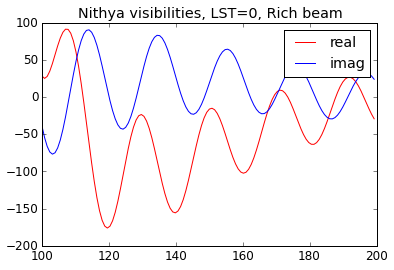

In [78]:
plt.plot(visdatrich['freq']/1.e6,real(visdatrich['skyvis_freq'][0,:,0]),'r')
plt.plot(visdatrich['freq']/1.e6,imag(visdatrich['skyvis_freq'][0,:,0]),'b')
#plt.ylim([-100,800])
plt.legend(['real','imag'])
plt.title('Nithya visibilities, LST=0, Rich beam')

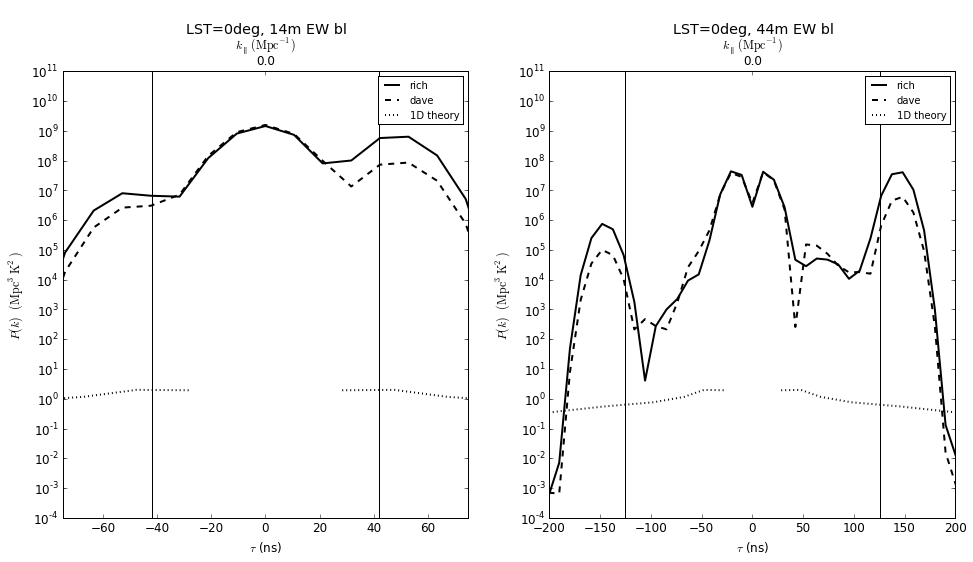

In [68]:
fig = plt.figure(num=None, figsize=(16, 8), dpi=80)

delays,visrich_delayspec_shortbl = vis_to_delay_spec(visdatrich['skyvis_freq'][0,desiredindices,0],richarea)
delays,visdave_delayspec_shortbl = vis_to_delay_spec(visdatdave['skyvis_freq'][0,desiredindices,0],davearea)

delays,visrich_delayspec_longbl = vis_to_delay_spec(visdatrich['skyvis_freq'][17,desiredindices,0],richarea)
delays,visdave_delayspec_longbl = vis_to_delay_spec(visdatdave['skyvis_freq'][17,desiredindices,0],davearea)

ax1 = fig.add_subplot(121)
ax1.semilogy(delays, abs(visrich_delayspec_shortbl)**2 ,'k-',linewidth=2,label='rich')
ax1.semilogy(delays, abs(visdave_delayspec_shortbl)**2 ,'k--',linewidth=2,label='dave')
plt.title('\nLST=0deg, 14m EW bl\n\n')
plotjunk(ax1,14*3.,[-75.,75.])

ax11 = fig.add_subplot(122)
ax11.semilogy(delays, abs(visrich_delayspec_longbl)**2 ,'k-',linewidth=2,label='rich')
ax11.semilogy(delays, abs(visdave_delayspec_longbl)**2 ,'k--',linewidth=2,label='dave')
plt.title('\nLST=0deg, 44m EW bl\n\n')
plotjunk(ax11,42*3.,[-200,200.])

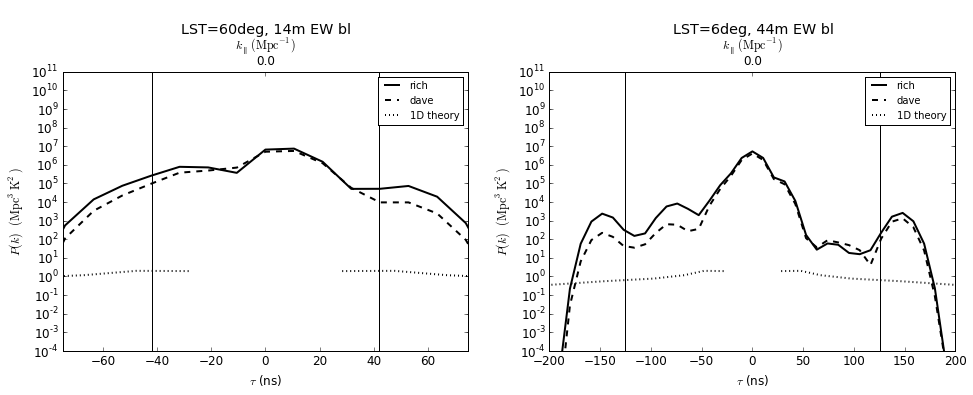

In [70]:
fig = plt.figure(num=None, figsize=(16, 5), dpi=80)

delays,visrich_delayspec_shortbl = vis_to_delay_spec(visdatrich['skyvis_freq'][0,desiredindices,18],1)
delays,visdave_delayspec_shortbl = vis_to_delay_spec(visdatdave['skyvis_freq'][0,desiredindices,18],1)

delays,visrich_delayspec_longbl = vis_to_delay_spec(visdatrich['skyvis_freq'][17,desiredindices,18],1)
delays,visdave_delayspec_longbl = vis_to_delay_spec(visdatdave['skyvis_freq'][17,desiredindices,18],1)

ax1 = fig.add_subplot(121)
ax1.semilogy(delays, abs(visrich_delayspec_shortbl)**2 ,'k-',linewidth=2,label='rich')
ax1.semilogy(delays, abs(visdave_delayspec_shortbl)**2 ,'k--',linewidth=2,label='dave')
plt.title('\nLST=60deg, 14m EW bl\n\n')
plotjunk(ax1,14*3.,[-75.,75.])

ax11 = fig.add_subplot(122)
ax11.semilogy(delays, abs(visrich_delayspec_longbl)**2 ,'k-',linewidth=2,label='rich')
ax11.semilogy(delays, abs(visdave_delayspec_longbl)**2 ,'k--',linewidth=2,label='dave')
plt.title('\nLST=6deg, 44m EW bl\n\n')
plotjunk(ax11,42*3.,[-200,200.])